Dealing with class imbalance:
- resampling techniques
    - under or over sampling random vs informed
    - SMOTE synthetic minor ...
- kappa statistics/ MCC Metric
- multiclass mcc "comparing two k-category assignments by a k-category correlation coeeficient"


spatial pyramid pooling in deep convolutional networks for visual recognition

In [ ]:
from keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np

class MY_Generator(Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([
            resize(imread(file_name), (28, 28))
               for file_name in batch_x]), np.array(batch_y)

In [12]:
from keras.utils import Sequence
class MY_Generator(Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        image = [np.asarray(Image.open(file_name).resize([299,299])) for file_name in batch_x]
        image = image/np.amax(image)
       
        return np.array(image), np.array(batch_y)

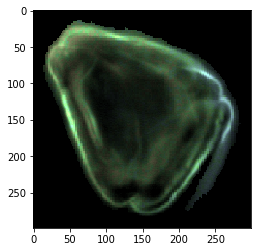

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [7]:
im=np.asarray(Image.open(files[1]).resize([299,299]))
im = im/np.amax(im)
import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()
im

In [13]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from pathlib import Path
import keras
import numpy as np
from PIL import Image

p = Path('./data/euc/') 
files = list(p.glob('**/*.png'))
#files = str(files).split("'")
#files = [ files[i] for i in list(range(1,len(files),2)) ]
classes = str(files).split('/')
classes = [ classes[i] for i in list(range(2,len(classes),3)) ]
classnames, indices = np.unique(classes, return_inverse=True)
labels = keras.utils.to_categorical(indices, len(np.unique(indices)))

In [ ]:
my_training_batch_generator

In [17]:
batch_size = 53
num_epochs = 10
activation = "relu"
LR = 0.05
L2 = 0.001
num_training_samples = 106

my_training_batch_generator = MY_Generator(files, labels, batch_size)
#my_validation_batch_generator = My_Generator(validation_filenames, GT_validation, batch_size)

mlp = Sequential([
    Flatten(input_shape = (299, 299, 3), name = "flatten"),
    Dense(200, name = "hidden_1", kernel_regularizer=regularizers.l2(L2),),
    Activation(activation, name = "act_hidden_1"),
    Dense(2, name = "out"),
    Activation("softmax", name = "act_out")
    ])

sgd = optimizers.SGD(lr=LR, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer = sgd,
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

history = mlp.fit_generator(generator=my_training_batch_generator,
                                          steps_per_epoch=(num_training_samples // batch_size),
                                          epochs=num_epochs,
                                          verbose=1,
                                          #validation_data=my_validation_batch_generator,
                                          #validation_steps=(num_validation_samples // batch_size),
                                          use_multiprocessing=True,
                                          workers=16,
                                          max_queue_size=32,
                             shuffle = True)

Epoch 1/10
1/2 [==============>...............] - ETA: 11s - loss: 0.9819 - acc: 0.9434

Exception in thread Thread-127:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/florianmuthreich/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 565, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/home/florianmuthreich/.local/lib/python3.5/site-packages/keras/utils/data_utils.py", line 548, in <lambda>
    initargs=(seqs,))
  File "/usr/lib/python3.5/multiprocessing/context.py", line 118, in Pool
    context=self.get_context())
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 168, in __init__
    self._repopulate_pool()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 233, in _repopulate_pool
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File 

2/2 [==============================] - 14s 7s/step - loss: 8.7534 - acc: 0.4717
Epoch 2/10


KeyboardInterrupt: 

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')




In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])
# train the model on the new data for a few epochs
model.fit_generator(generator=my_training_batch_generator,
                                          steps_per_epoch=(num_training_samples // batch_size),
                                          epochs=10,
                                          verbose=1,
                                          use_multiprocessing=True,
                                          workers=16,
                                          max_queue_size=32,
                             shuffle = True)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.



In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)

In [ ]:
from pathlib import Path
p = Path('./data/imgs/') 
classes = [x for x in p.iterdir() if x.is_dir()]
files = list(p.glob('**/*.jpg'))

In [ ]:
str(files[200000])

In [ ]:
# euc laptop
from pathlib import Path
p = Path('./data/') 
#classes = [x for x in p.iterdir() if x.is_dir()]
files = list(p.glob('**/*.png'))
classes = str(files).split('/')
classes = [ classes[i] for i in list(range(1,len(classes),2)) ]

In [ ]:
import matplotlib.pyplot as plt
#plt.imshow(plt.imread(str(files[1])))
#plt.show()

In [ ]:
from PIL import Image
im = Image.open(str(files[1])).resize([28,28])
#im = im.resize([28,50])
plt.imshow(im)
plt.show()

In [ ]:
import numpy as np
im = np.asarray(im)
im.shape

In [ ]:
import keras
keras.utils.to_categorical(classes, len(np.unique(classes)))

In [ ]:
classnames, indices = np.unique(classes, return_inverse=True)
keras.utils.to_categorical(indices, len(np.unique(indices)))

In [ ]:
files2[3]

In [ ]:
model.summary()